# Blockage modelling

This example shows how to use the Rankine-Half-Body model for modelling the blockage effect. We need the following imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV
import foxes.constants as FC

First, we setup the model book and the wind farm, here we pick 20 x 10 turbines on a regular grid:

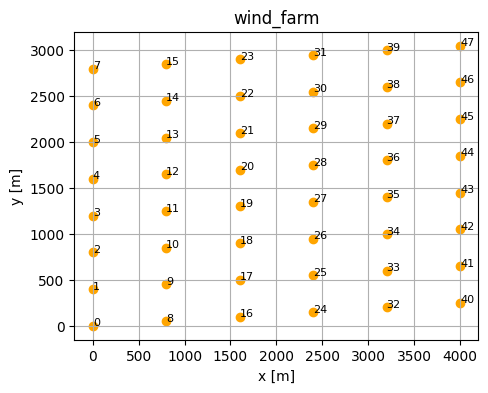

In [2]:
mbook = foxes.ModelBook()

farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm=farm,
    xy_base=[0.0, 0.0],
    step_vectors=[[800.0, 50.0], [0., 400.0]],
    steps=[6, 8],
    turbine_models=["DTU10MW"],
    verbosity=0
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(8, 4))
plt.show()

As wind conditions, we choose a single wind direction state from 270 degrees:

In [3]:
# create ambient wind conditions, a single uniform state:
states = foxes.input.states.SingleStateStates(ws=8.0, wd=270.0, ti=0.04, rho=1.225)

For induction models, the `Iterative` algorithm should be invoked. This is due to the fact that upstream turbines can be influenced by the induction zone of a turbine, which the `Downstream` algorithm simply would not notice.

By default the `Iterative` algorithm applies under-relaxation of the variable `FV.CT`, corresponding to calling `aglo.set_urelax(pre_wake={FV.CT: 0.5})` before calculations. This means that for each iteration the freshly calculated value is mixed with the result from the previous iteration. This avoids wakes switching on and off repeatedly between subsequent iterations in some cases, ensuring convergence also in the vicinity of the cut-in and cut-out regions of the thrust curve. The convergence criteria can also be modified by setting the parameter `conv_crit`, see API.

In [4]:
algo = foxes.algorithms.Iterative(
    mbook,
    farm,
    states=states,
    rotor_model="centre",
    wake_models=["RHB", "Bastankhah025_linear_lim_k004"],
    wake_frame="rotor_wd",
    partial_wakes_model="auto",
    chunks={FC.STATE: None, FC.POINT: 4000},
    verbosity=1,
)

Notice the `RHB` model among the list of wake models. This is the [Rankine-Half-Body](https://www.fnc.co.uk/media/o5eosxas/a-potential-flow-model-for-wind-turbine-induction-and-wind-farm-blockage.pdf) induction model, adding an induction zone for each turbine. We can now calculate the results:

In [5]:
with foxes.utils.runners.DaskRunner() as runner:
    farm_results = runner.run(algo.calc_farm)

print(farm_results)


Algorithm Iterative: Iteration 0


Initializing algorithm 'Iterative'
Initializing model 'Iterative'
Initializing model 'SingleStateStates'
Initializing model 'centre'
Initializing model 'basic_ctrl_prer'
Initializing model 'DTU10MW'
Turbine type 'DTU10MW': Reading static data from context 'power_ct_curve'
Path: /home/jonas/gits/wakes/foxes/foxes/data/power_ct_curves/DTU-10MW-D178d3-H119.csv
Initializing model 'basic_ctrl_postr'
Initializing model 'basic_ctrl'
Initializing model 'rotor_wd'
Partial wakes 'auto': Applying RotorPoints to ['RHB']
Partial wakes 'auto': Applying PartialAxiwake to ['Bastankhah025_linear_lim_k004']
Initializing model 'RHB'
Initializing model 'ws_linear_lim'
Initializing model 'Bastankhah025_linear_lim_k004'
Initializing model 'RotorPoints1'
Initializing model 'PartialAxiwake10'
Initializing model 'auto'

--------------------------------------------------
  Running Iterative: calc_farm
--------------------------------------------------
  n_states : 1
  n_turbi

[########################################] | 100% Completed | 102.14 ms


Input data:

 <xarray.Dataset>
Dimensions:      (state: 1, turbine: 48, tmodels: 1)
Coordinates:
  * state        (state) int64 0
  * tmodels      (tmodels) <U7 'DTU10MW'
Dimensions without coordinates: turbine
Data variables:
    weight       (state, turbine) float64 dask.array<chunksize=(1, 48), meta=np.ndarray>
    tmodel_sels  (state, turbine, tmodels) bool dask.array<chunksize=(1, 48, 1), meta=np.ndarray> 


Output farm variables: AMB_CT, AMB_P, AMB_REWS, AMB_REWS2, AMB_REWS3, AMB_RHO, AMB_TI, AMB_WD, AMB_YAW, CT, D, H, P, REWS, REWS2, REWS3, RHO, TI, WD, X, Y, YAW, order, weight

Chunks: {'state': None, 'point': 4000}


Calculating 1 states for 48 turbines
[                                        ] | 0% Completed | 275.37 us

[########################################] | 100% Completed | 102.55 ms


Algorithm Iterative: Iteration 1

[                                        ] | 0% Completed | 348.07 us

[########################################] | 100% Completed | 102.72 ms

[                                        ] | 0% Completed | 486.51 us

[########################################] | 100% Completed | 102.83 ms


DefaultConv: Convergence check
  REWS: delta = 7.255e-01, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 5.379e-03, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 2

[                                        ] | 0% Completed | 385.82 us

[########################################] | 100% Completed | 103.11 ms

[                                        ] | 0% Completed | 345.19 us

[########################################] | 100% Completed | 102.28 ms


DefaultConv: Convergence check
  REWS: delta = 1.314e-01, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 2.330e-03, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 3

[                                        ] | 0% Completed | 232.19 us

[########################################] | 100% Completed | 101.97 ms

[                                        ] | 0% Completed | 274.15 us

[########################################] | 100% Completed | 102.04 ms


DefaultConv: Convergence check
  REWS: delta = 2.071e-02, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 1.206e-03, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 4

[                                        ] | 0% Completed | 342.07 us

[########################################] | 100% Completed | 102.48 ms

[                                        ] | 0% Completed | 237.75 us

[########################################] | 100% Completed | 142.97 ms


DefaultConv: Convergence check
  REWS: delta = 1.193e-03, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 5.979e-04, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 5

[                                        ] | 0% Completed | 268.50 us

[########################################] | 100% Completed | 102.78 ms

[                                        ] | 0% Completed | 338.49 us

[########################################] | 100% Completed | 102.34 ms


DefaultConv: Convergence check
  REWS: delta = 8.805e-04, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 2.997e-04, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 6

[                                        ] | 0% Completed | 346.60 us

[########################################] | 100% Completed | 103.14 ms

[                                        ] | 0% Completed | 310.58 us

[########################################] | 100% Completed | 104.07 ms


DefaultConv: Convergence check
  REWS: delta = 4.138e-04, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 1.565e-04, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 7

[                                        ] | 0% Completed | 215.69 us

[########################################] | 100% Completed | 102.17 ms

[                                        ] | 0% Completed | 283.16 us

[########################################] | 100% Completed | 104.47 ms


DefaultConv: Convergence check
  REWS: delta = 2.236e-04, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 8.270e-05, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 8

[                                        ] | 0% Completed | 291.69 us

[########################################] | 100% Completed | 102.34 ms

[                                        ] | 0% Completed | 303.02 us

[########################################] | 100% Completed | 102.37 ms


DefaultConv: Convergence check
  REWS: delta = 1.168e-04, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 4.358e-05, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 9

[                                        ] | 0% Completed | 246.00 us

[########################################] | 100% Completed | 101.98 ms

[                                        ] | 0% Completed | 181.43 us

[########################################] | 100% Completed | 102.71 ms


DefaultConv: Convergence check
  REWS: delta = 6.126e-05, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 2.291e-05, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 10

[                                        ] | 0% Completed | 496.65 us

[########################################] | 100% Completed | 103.02 ms

[                                        ] | 0% Completed | 333.19 us

[########################################] | 100% Completed | 101.81 ms


DefaultConv: Convergence check
  REWS: delta = 3.203e-05, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 1.202e-05, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 11

[                                        ] | 0% Completed | 324.89 us

[########################################] | 100% Completed | 101.84 ms

[                                        ] | 0% Completed | 287.42 us

[########################################] | 100% Completed | 101.97 ms


DefaultConv: Convergence check
  REWS: delta = 1.672e-05, lim = 1.000e-05  --  FAILED
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 6.290e-06, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 12

[                                        ] | 0% Completed | 344.44 us

[########################################] | 100% Completed | 102.42 ms

[                                        ] | 0% Completed | 296.50 us

[########################################] | 100% Completed | 102.00 ms


DefaultConv: Convergence check
  REWS: delta = 8.713e-06, lim = 1.000e-05  --  OK
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 3.286e-06, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 13

[                                        ] | 0% Completed | 215.45 us

[########################################] | 100% Completed | 101.98 ms

[                                        ] | 0% Completed | 271.48 us

[########################################] | 100% Completed | 102.67 ms


DefaultConv: Convergence check
  REWS: delta = 4.534e-06, lim = 1.000e-05  --  OK
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 1.714e-06, lim = 1.000e-06  --  FAILED

Algorithm Iterative: Iteration 14

[                                        ] | 0% Completed | 199.90 us

[########################################] | 100% Completed | 103.30 ms

[                                        ] | 0% Completed | 282.29 us

[########################################] | 100% Completed | 102.16 ms


DefaultConv: Convergence check
  REWS: delta = 2.356e-06, lim = 1.000e-05  --  OK
  TI  : delta = 0.000e+00, lim = 1.000e-06  --  OK
  CT  : delta = 8.926e-07, lim = 1.000e-06  --  OK

Algorithm Iterative: Convergence reached.

<xarray.Dataset>
Dimensions:    (state: 1, turbine: 48)
Coordinates:
  * state      (state) int64 0
Dimensions without coordinates: turbine
Data variables: (12/25)
    AMB_CT     (state, turbine) float64 0.814 0.814 0.814 ... 0.814 0.814 0.814
    AMB_P      (state, turbine) float64 3.731e+03 3.731e+03 ... 3.731e+03
    AMB_REWS   (state, turbine) float64 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
    AMB_REWS2  (state, turbine) float64 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
    AMB_REWS3  (state, turbine) float64 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
    AMB_RHO    (state, turbine) float64 1.225 1.225 1.225 ... 1.225 1.225 1.225
    ...         ...
    X          (state, turbine) float64 0.0 0.0 0.0 0.0 ... 4e+03 4e+03 4e+03
    Y          (state, turbine) flo

The following visualizes the flow field around the most south-westerly turbine in the wind farm:

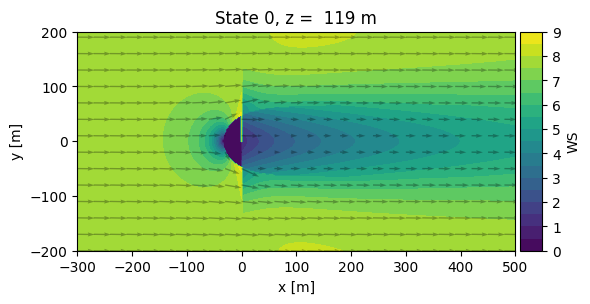

In [6]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(
    FV.WS,
    figsize=(6, 5),
    resolution=2,
    xmin=-300, xmax=500,
    ymin=-200, ymax=200,
    levels=20,
    quiver_n=15,
    quiver_pars={"scale": 0.25, "alpha": 0.3}
)
fig = next(g)
plt.show()

The induction zone in front of the rotor is clearly visible. For the complete wind farm, the individual induction zones merge:

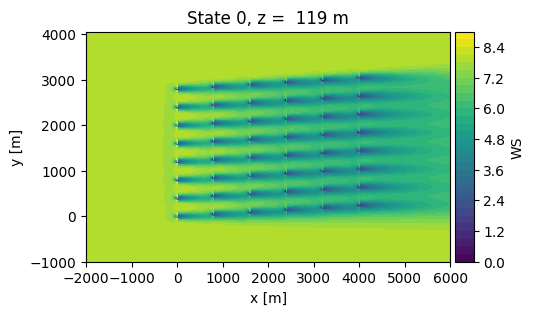

In [7]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(
    FV.WS,
    figsize=(5, 5),
    resolution=10,
    xspace=2000,
    yspace=1000,
    levels=30,
    #vmax=7.95,
)
fig = next(g)
plt.show()

The individual contributions to the blockage zone are visible when plotting the wind speed along a straight line in y direction, at fixed x in front of the first row of turbines:

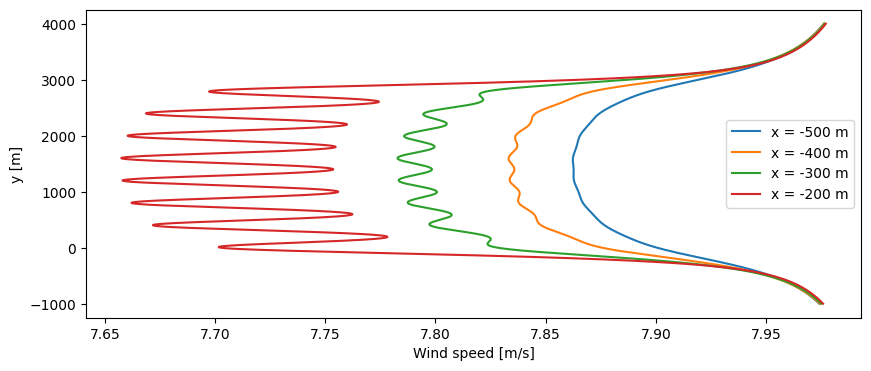

In [8]:
H = mbook.turbine_types["DTU10MW"].H
n_points = 10000
points = np.zeros((1, n_points, 3))
points[:, :, 1] = np.linspace(-1000, 4000, n_points)[None, :]
points[:, :, 2] = H

xlist = [-500, -400, -300, -200]
fig, ax = plt.subplots(figsize=(10, 4))
for x in xlist:
    points[:, :, 0] = x
    point_results = algo.calc_points(farm_results, points)
    ax.plot(point_results[FV.WS][0, :], points[0, :, 1], label=f"x = {x} m")
ax.set_ylabel("y [m]")
ax.set_xlabel("Wind speed [m/s]")
ax.legend()
plt.show()